In [1]:
import os

In [2]:
os.chdir("../")

In [3]:
%pwd

'c:\\Users\\yasba\\OneDrive\\Documents\\Projects\\Audio_Classification_UrbanSound8K'

In [4]:
import tensorflow as tf

In [5]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class EvaluationConfig:
    path_of_model: Path
    test_data: Path
    train_data: Path

In [6]:
from Audio_Classification.constants import *
from Audio_Classification.utils.common import read_yaml, create_directories, save_json

In [7]:
class ConfigurationManager:

    
    def get_validation_config(self) -> EvaluationConfig:
        eval_config = EvaluationConfig(
            path_of_model="artifacts/training/audio_classification_model.h5",
            train_data="artifacts/data_ingestion/splits/train.csv",
            test_data = "artifacts/data_ingestion/splits/test.csv",
        )
        return eval_config

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from keras.models import load_model

In [9]:
class Evaluation:
    def __init__(self, config: EvaluationConfig):
        self.config = config

    
    def evaluation(self):
        # Evaluation logic here
        self.model = load_model(self.config.path_of_model)

        self.test_df = pd.read_csv(self.config.test_data)
        X_test = self.test_df["mfccs"].apply(lambda x: np.fromstring(x.replace('\n', ' ').strip('[]'), sep=' '))
        self.X_test = np.vstack(X_test)
        self.y_test = np.array(self.test_df["class"].tolist())

        self.class_names = ['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
                        'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
                        'drilling'
                    ]

        self.predictions = self.model.predict(self.X_test)
        self.predicted_classes = np.argmax(self.predictions, axis=1)
        self.true_classes = self.y_test

        # Step 2: Evaluate accuracy
        self.accuracy = accuracy_score(self.true_classes, self.predicted_classes)
        print(f"Accuracy: {self.accuracy:.2%}\n")

        # Step 3: Classification report
        self.report = classification_report(self.true_classes, self.predicted_classes, target_names=self.class_names, output_dict=True)
        print("Classification Report:\n")
        print(self.report)

        # Step 4: Confusion Matrix
        conf_matrix = confusion_matrix(self.true_classes, self.predicted_classes)

        # Step 5: Plot Confusion Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

        print(f"loss : {self.model.evaluate(self.X_test, self.y_test, verbose=0)[0]} ")

        # Save as json file
        evaluation_data = {
            "loss": self.model.evaluate(self.X_test, self.y_test, verbose=0)[0],
            "accuracy": self.accuracy,
            "classification_report": self.report,
            "confusion_matrix": conf_matrix.tolist(),
        }

        save_json(path=Path("scores.json"), data=evaluation_data)

55/55 [==============================] - 0s 2ms/step
Accuracy: 78.53%

Classification Report:

{'dog_bark': {'precision': 0.6545454545454545, 'recall': 0.8866995073891626, 'f1-score': 0.7531380753138075, 'support': 203.0}, 'children_playing': {'precision': 0.9436619718309859, 'recall': 0.7790697674418605, 'f1-score': 0.8535031847133757, 'support': 86.0}, 'car_horn': {'precision': 0.6, 'recall': 0.7213114754098361, 'f1-score': 0.6550868486352357, 'support': 183.0}, 'air_conditioner': {'precision': 0.8054054054054054, 'recall': 0.7412935323383084, 'f1-score': 0.7720207253886009, 'support': 201.0}, 'street_music': {'precision': 0.9333333333333333, 'recall': 0.7475728155339806, 'f1-score': 0.8301886792452831, 'support': 206.0}, 'gun_shot': {'precision': 0.8527918781725888, 'recall': 0.8704663212435233, 'f1-score': 0.8615384615384616, 'support': 193.0}, 'siren': {'precision': 0.9166666666666666, 'recall': 0.6111111111111112, 'f1-score': 0.7333333333333334, 'support': 72.0}, 'engine_idling':

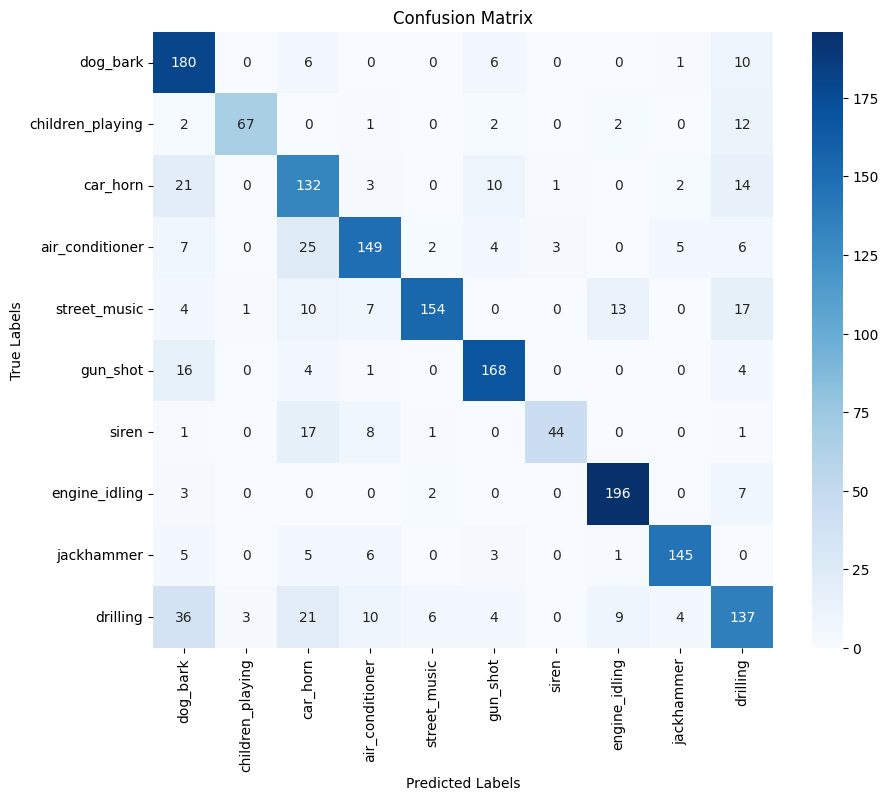

loss : 0.7386583685874939 
[2024-12-24 17:39:10,938: INFO: common: json file saved at: scores.json]


In [10]:
try:
    config = ConfigurationManager()
    val_config = config.get_validation_config()
    evaluation = Evaluation(val_config)
    evaluation.evaluation()
    
except Exception as e:
   raise e